# K-Means Clustering for Heart Disease Analysis | LLM Model Included

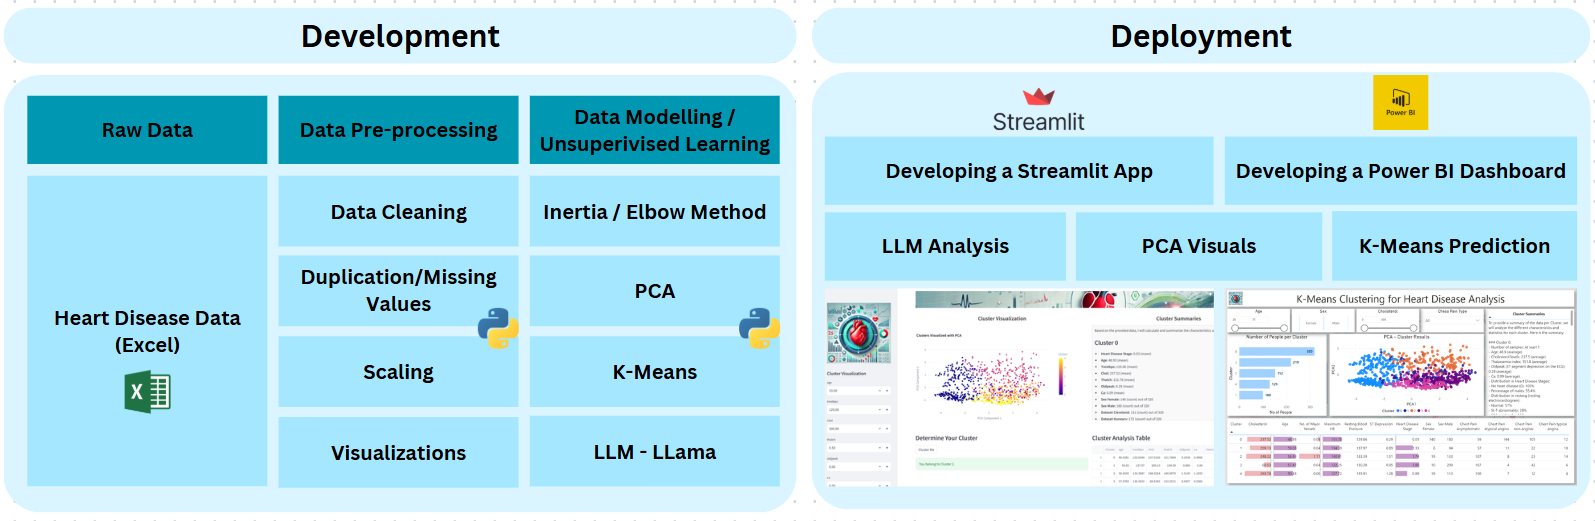

In [87]:
import os
from IPython.display import Image
Image("dev 2.png",width=900, height=700)

## Agenda:
1. Loading the Raw Data from Kaggle
2. Data Pre-processing
3. Inertia - Elbow Method - Dendrogram
4. Running K-Means
5. Principal Component Analysis
6. Results Analysis
7. LLM LLama Results Analysis

## 1. Loading the Raw Data from Kaggle

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the dataset
data = pd.read_csv('heart_disease_uci.csv')

#renaming
data.rename({'num': 'Heart Disease Stage'}, axis=1, inplace=True)

# source: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data 

data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Heart Disease Stage
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 2. Data Pre-processing

In [44]:
# Investigate all the elements whithin each Feature 

for column in data:
    unique_vals = np.unique(data[column].astype(str).fillna('0'))
    nr_values = len(unique_vals)
    if nr_values <= 12:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature id :920
The number of values for feature age :50
The number of values for feature sex :2 -- ['Female' 'Male']
The number of values for feature dataset :4 -- ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
The number of values for feature cp :4 -- ['asymptomatic' 'atypical angina' 'non-anginal' 'typical angina']
The number of values for feature trestbps :62
The number of values for feature chol :218
The number of values for feature fbs :3 -- ['False' 'True' 'nan']
The number of values for feature restecg :4 -- ['lv hypertrophy' 'nan' 'normal' 'st-t abnormality']
The number of values for feature thalch :120
The number of values for feature exang :3 -- ['False' 'True' 'nan']
The number of values for feature oldpeak :54
The number of values for feature slope :4 -- ['downsloping' 'flat' 'nan' 'upsloping']
The number of values for feature ca :5 -- ['0.0' '1.0' '2.0' '3.0' 'nan']
The number of values for feature thal :4 -- ['fixed defect' 'nan' 'normal' 

In [50]:
# Checking for null values
data.isnull().sum()

id                     0
age                    0
sex                    0
dataset                0
cp                     0
trestbps               0
chol                   0
fbs                    0
restecg                0
thalch                 0
exang                  0
oldpeak                0
slope                  0
ca                     0
thal                   0
Heart Disease Stage    0
dtype: int64

In [48]:
# Handle missing values
# Fill numerical columns with their median
numerical_cols = data.select_dtypes(include=[np.number]).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Fill categorical columns with the most frequent value (mode)
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

C:\Users\pitsi\AppData\Local\Temp\ipykernel_276\3655313560.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


In [52]:
# Data Cleaning
data.drop('id', axis=1, inplace=True)  # Drop ID column

# Categorical variables to be one-hot encoded
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'Heart Disease Stage']

# One-hot encoding using get_dummies
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

In [88]:
data_encoded.head()

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect,Heart Disease Stage_0,Heart Disease Stage_1,Heart Disease Stage_2,Heart Disease Stage_3,Heart Disease Stage_4
0,63,145.0,233.0,150.0,2.3,0.0,False,True,True,False,...,False,False,True,False,False,True,False,False,False,False
1,67,160.0,286.0,108.0,1.5,3.0,False,True,True,False,...,True,False,False,True,False,False,False,True,False,False
2,67,120.0,229.0,129.0,2.6,2.0,False,True,True,False,...,True,False,False,False,True,False,True,False,False,False
3,37,130.0,250.0,187.0,3.5,0.0,False,True,True,False,...,False,False,False,True,False,True,False,False,False,False
4,41,130.0,204.0,172.0,1.4,0.0,True,False,True,False,...,False,True,False,True,False,True,False,False,False,False


In [78]:
# Standardize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_encoded)

## 3. Inertia - Elbow Method - Dendrogram

### Inertia
- Definition: Inertia measures the sum of squared distances between each data point and the centroid of the cluster to which it belongs. Lower inertia indicates tighter and more cohesive clusters.
- Role in K-means: Inertia helps evaluate the quality of clustering by quantifying how well the clusters represent the data points.

### Elbow Method
- Purpose: The Elbow Method identifies the optimal number of clusters by plotting inertia against the number of clusters (k). The "elbow point" marks the best trade-off between reducing inertia and increasing the number of clusters.
- Key Insight: Adding more clusters always reduces inertia, but after a certain point, the improvement diminishes. The "elbow" is where inertia reduction slows significantly.

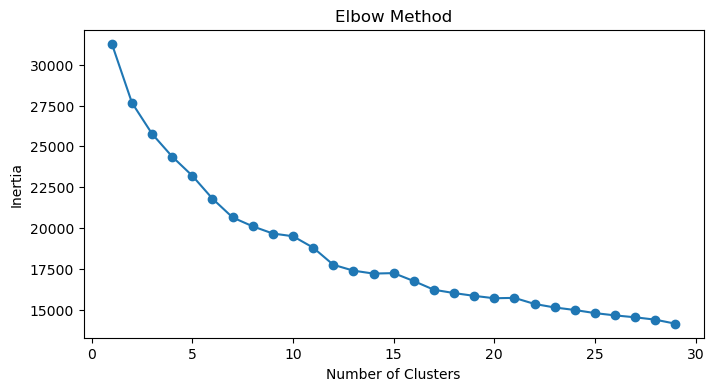

In [92]:
# Elbow Method for Best Number of Clusters
inertia = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Dendrogram
- Definition: A dendrogram is a tree-like diagram used in hierarchical clustering to visualize the process of merging data points into clusters based on their similarity.
- Use in K-means: While not directly used in K-means, dendrograms can help determine the number of clusters by analyzing the largest vertical distance (linkage) between two horizontal lines before merging clusters.

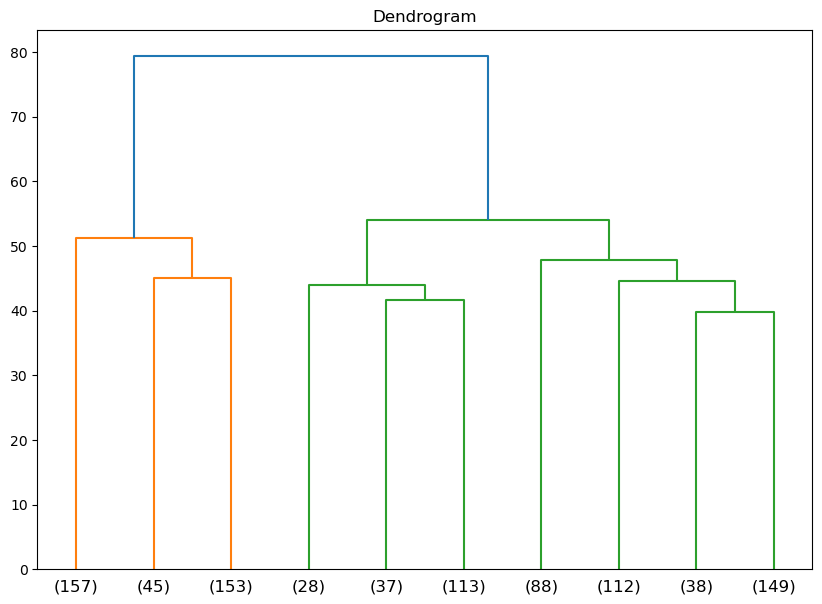

In [10]:
# Hierarchical Clustering Dendrogram
linked = linkage(scaled_features, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=10)
plt.title('Dendrogram')
plt.show()

## 4. Running K-Means

### K-Means Clustering
- Definition: K-Means is an unsupervised machine learning algorithm that partitions data into k clusters, where each data point belongs to the cluster with the nearest centroid, minimizing intra-cluster variance.
- Process: The algorithm iteratively:
    - Assigns data points to the nearest cluster centroid.
    - Updates centroids by averaging the data points in each cluster until convergence (when assignments no longer change).

In [94]:
# Run K-means
optimal_clusters = 5  # Based on elbow/dendrogram
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)
data.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Heart Disease Stage,Cluster
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,1
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,2
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


## 5. Principal Component Analysis

### PCA in K-Means
- Purpose: Principal Component Analysis (PCA) reduces the dimensionality of the dataset while preserving as much variance as possible. In K-Means, PCA helps visualize clusters in 2D or 3D space and improves performance by removing noise and redundant features.
- How It Helps: PCA transforms data into a set of principal components, which are linear combinations of the original features. This aids K-Means by simplifying complex datasets and making clusters more distinct in reduced dimensions.

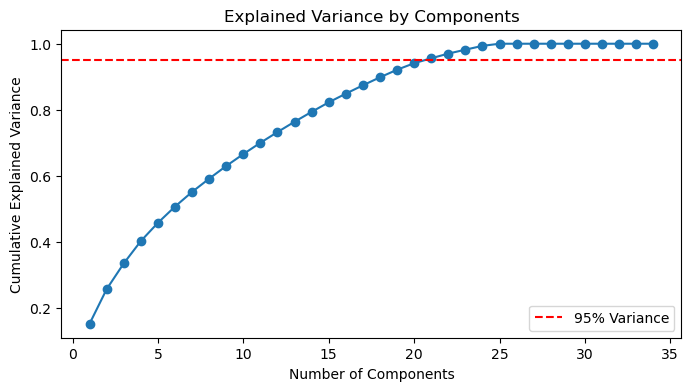

In [96]:
# PCA for Dimensionality Reduction
pca = PCA()
pca_features = pca.fit_transform(scaled_features)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()

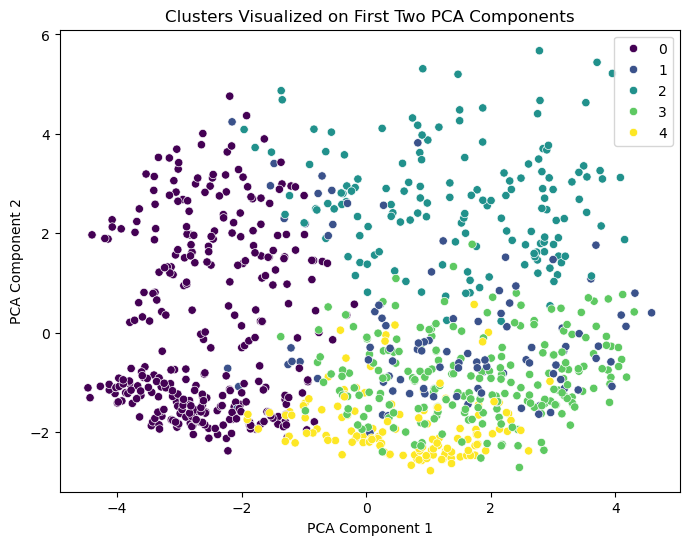

In [98]:
# Visualize Clusters
pca_2d = pca_features[:, :2]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('Clusters Visualized on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

## 6. Results Analysis

In [110]:
data.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Heart Disease Stage,Cluster
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,1
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,2
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


In [120]:
# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = [col for col in data.columns if col not in numeric_columns and col != 'Cluster']

# Numeric aggregation
numeric_analysis = data.groupby('Cluster', as_index=False)[numeric_columns].mean()
numeric_analysis = numeric_analysis[['Cluster', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca',
       'Heart Disease Stage']]

# Categorical aggregation: Count occurrences of each category per cluster
categorical_analysis = {}
for col in categorical_columns:
    counts = data.groupby('Cluster')[col].value_counts().unstack(fill_value=0)
    counts.columns = [f"{col}_{val}" for val in counts.columns]  # Rename columns to include category values
    categorical_analysis[col] = counts

# Combine categorical counts into a single DataFrame
categorical_analysis_df = pd.concat(categorical_analysis.values(), axis=1).reset_index()

# Combine numeric and categorical summaries
cluster_analysis = pd.merge(numeric_analysis, categorical_analysis_df, on='Cluster', how='left')

# Display the combined analysis
cluster_analysis

,Cluster,age,trestbps,chol,thalch,oldpeak,ca,Heart Disease Stage,sex_Female,sex_Male,...,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,0.0,48.928125,129.059375,237.515625,151.784375,0.293438,0.090625,0.031250,140,180,...,229,35,303,17,5,211,104,5,308,7
1,1.0,59.030000,137.970000,209.130000,134.390000,0.885000,0.040000,1.330000,6,94,...,36,42,70,30,11,81,8,9,75,16
2,2.0,56.434211,133.394737,248.322368,140.907895,1.514474,1.105263,1.736842,19,133,...,57,2,70,82,14,90,48,14,28,110
3,3.0,57.470320,130.283105,69.534247,122.251142,0.945662,0.036530,1.799087,10,209,...,127,76,107,112,32,144,43,12,159,48
4,4.0,50.434109,135.906977,263.759690,127.720930,1.281395,0.000000,0.891473,19,110,...,104,24,33,96,1,128,0,6,112,11


## 7. LLM LLama Results Analysis

In [126]:
# Asking an LLM so summarize the results

from groq import Groq
# Initialize the Groq client
# client = Groq(api_key='')

# Convert DataFrame to JSON or other structured format
data_json = cluster_analysis.to_json(orient='records')

# Define the prompt
prompt = f"Summarize the following data. Specifically, I want a summary per Cluster with the main characteristics and statistics that each cluster has. The cluster column already exists and has 5 clusters (0 to 4). Column 'Heart Disease Stage' is an important column as it has the heart disease stages [0=no heart disease; 1,2,3,4 = stages of heart disease]:\n{data_json}"

# Define the model you want to use
model_name = 'llama-3.1-8b-instant'  # Change this to the model you want to use

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "you are a helpful assistant."
        },
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model=model_name,
)

print(chat_completion.choices[0].message.content)

cluster_summaries = chat_completion.choices[0].message.content

## Available models: https://console.groq.com/docs/models
## Groq LLM Tutorial: https://youtu.be/Gi-2a05hbzo?si=vVhN4IZA8xsqV_nY 

Based on the given data, we'll create a summary of each cluster, including the main characteristics and statistics. 

### Cluster 0 Summary

- **Age**: 48.93 years old (average)
- **Heart Disease Stage**: 0.03125 (no heart disease)
- **Sex Ratio**: 1.27 females to 1 male (140 females, 180 males)
- **Distribution across datasets**:
  - Cleveland: 131
  - Hungary: 172
  - Switzerland: 2
  - VA Long Beach: 15
- **Other characteristics**:
  - Trestbps average: 129.06
  - Chol average: 237.52
  - Thalch average: 151.78
  - Ca average: 0.09
  - Oldpeak average: 0.29

### Cluster 1 Summary

- **Age**: 59.03 years old (average)
- **Heart Disease Stage**: 1.33 (early stage)
- **Sex Ratio**: 0.078 females to 1 male (6 females, 94 males)
- **Distribution across datasets**:
  - Cleveland: 16
  - Hungary: 12
  - Switzerland: 4
  - VA Long Beach: 68
- **Other characteristics**:
  - Trestbps average: 137.97
  - Chol average: 209.13
  - Thalch average: 134.39
  - Ca average: 0.04
  - Oldpeak average: 

## 8. Exporting our Models/Results/Data

In [83]:
# Storing our results
import pickle
import json

with open('kmeans_model.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Save cluster_summaries as a pickle file
with open('cluster_summaries.pkl', 'wb') as summary_file:
    pickle.dump(cluster_summaries, summary_file)

# Save PCA first two components and cluster labels
pca_2d_df = pd.DataFrame(pca_features[:, :2], columns=['PCA1', 'PCA2'])
pca_2d_df['Cluster'] = data['Cluster'] # Assuming 'Cluster' is in data_encoded

# Save to Excel
pca_2d_df.to_excel('pca_2d.xlsx', index=False)

# Export the cluster_analysis DataFrame to an Excel file
cluster_analysis.to_excel('cluster_analysis.xlsx', index=False)

# Exporting the data with predictions
data.to_excel('main_data_with_pred.xlsx', index=False)

# Export cluster_summaries to a text file
with open('cluster_summaries.txt', 'w') as file:
    file.write(json.dumps(cluster_summaries, indent=4)) 


In [81]:
cluster_summaries

str

# 9. Streamlit App

### Step 1 - Gathering the raw data and preparing it for K-Means

In [131]:
# Feature names based on the training data
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_options = {
    'sex': ['Female', 'Male'],
    'dataset': ['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
    'cp': ['asymptomatic', 'atypical angina', 'non-anginal', 'typical angina'],
    'fbs': ['False', 'True'],
    'restecg': ['lv hypertrophy', 'normal', 'st-t abnormality'],
    'exang': ['False', 'True'],
    'slope': ['downsloping', 'flat', 'upsloping'],
    'thal': ['fixed defect', 'normal', 'reversable defect'],
    'Heart Disease Stage': ['0', '1', '2', '3', '4']
}

# Collect user inputs
user_inputs = {}
for feature in numeric_features:
    user_inputs[feature] = st.sidebar.number_input(feature, value=0.0)

for feature, options in categorical_options.items():
    selected_value = st.sidebar.selectbox(feature, options)
    for option in options:
        user_inputs[f"{feature}_{option}"] = 1 if selected_value == option else 0

# Convert user inputs to a DataFrame
input_df = pd.DataFrame([user_inputs])

input_df

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect,Heart Disease Stage_0,Heart Disease Stage_1,Heart Disease Stage_2,Heart Disease Stage_3,Heart Disease Stage_4
0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0


## Step 2 - Building the Streamlit App

In [130]:
import streamlit as st
import pandas as pd
import plotly.express as px
from PIL import Image
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set Streamlit page configuration
st.set_page_config(layout="wide")

# Custom CSS to remove the top space
st.markdown(
    """
    <style>
    /* Remove default top margin and padding */
    .block-container {
        padding-top: 0rem;
    }
    .title {
        text-align: center;
        font-size: 32px;
        font-weight: bold;
        color: #333333;
    }
    .subheader {
        text-align: center;
        font-size: 24px;
        font-weight: bold;
        color: #555555;
    }
    .scrollable-summary {
        height: 420px;
        overflow-y: auto;
        border: 1px solid #ccc;
        padding: 10px;
        background-color: #f9f9f9;
    }
    </style>
    """,
    unsafe_allow_html=True,
)

# Load pre-trained model, scaler, and cluster summaries
with open('kmeans_model.pkl', 'rb') as model_file:
    kmeans = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Load PCA data from Excel
pca_2d_df = pd.read_excel('pca_2d.xlsx')

# Load cluster_analysis data from Excel
cluster_analysis = pd.read_excel('cluster_analysis.xlsx')

# Load cluster_summaries from pickle
try:
    with open('cluster_summaries.pkl', 'rb') as summary_file:
        cluster_summaries = pickle.load(summary_file)
except FileNotFoundError:
    cluster_summaries = None
    st.error("Cluster summaries file not found. Please generate it in the base code.")

# Load images
sidebar_image = Image.open('Pic1.png')
main_image = Image.open('Pic2.png')

# Sidebar for user inputs
st.sidebar.image(sidebar_image, use_column_width=True)
st.sidebar.header("Cluster Visualization")

# Feature names based on the training data
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_options = {
    'sex': ['Female', 'Male'],
    'dataset': ['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
    'cp': ['asymptomatic', 'atypical angina', 'non-anginal', 'typical angina'],
    'fbs': ['False', 'True'],
    'restecg': ['lv hypertrophy', 'normal', 'st-t abnormality'],
    'exang': ['False', 'True'],
    'slope': ['downsloping', 'flat', 'upsloping'],
    'thal': ['fixed defect', 'normal', 'reversable defect'],
    'Heart Disease Stage': ['0', '1', '2', '3', '4']
}

# Collect user inputs
user_inputs = {}
for feature in numeric_features:
    user_inputs[feature] = st.sidebar.number_input(feature, value=0.0)

for feature, options in categorical_options.items():
    selected_value = st.sidebar.selectbox(feature, options)
    for option in options:
        user_inputs[f"{feature}_{option}"] = 1 if selected_value == option else 0

# Convert user inputs to a DataFrame
input_df = pd.DataFrame([user_inputs])

# Main page layout
st.markdown('<h1 class="title">Cluster Analysis with PCA Visualization</h1>', unsafe_allow_html=True)
st.image(main_image, use_column_width=True)

# First Section: Split into two columns
left_col, right_col = st.columns(2)

with left_col:
    st.markdown('<h2 class="subheader">Cluster Visualization</h2>', unsafe_allow_html=True)
    fig = px.scatter(
        pca_2d_df, 
        x='PCA1', 
        y='PCA2', 
        color='Cluster', 
        title="Clusters Visualized with PCA", 
        labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2'},
        template='plotly'
    )
    st.plotly_chart(fig)

with right_col:
    st.markdown('<h2 class="subheader">Cluster Summaries</h2>', unsafe_allow_html=True)
    # Start the scrollable div
    summary_content = '<div class="scrollable-summary">'
    if isinstance(cluster_summaries, str):
        summary_content += f"<p>{cluster_summaries}</p>"
    elif cluster_summaries:
        for key, value in cluster_summaries.items():
            summary_content += f"<p><strong>Cluster {key}</strong>: {value}</p>"
    else:
        summary_content += "<p>No cluster summaries available.</p>"
    summary_content += "</div>"
    st.markdown(summary_content, unsafe_allow_html=True)

# Second Section: Split into two columns
second_left_col, second_right_col = st.columns(2)

with second_left_col:
    st.subheader("Determine Your Cluster")
    if st.button("Cluster Me"):
        # Predict the user's cluster
        cluster_id = kmeans.predict(scaler.transform(input_df))[0]
        st.success(f"You belong to Cluster {cluster_id}.")

with second_right_col:
    st.subheader("Cluster Analysis Table")
    # Display the cluster_analysis DataFrame with horizontal scrolling
    st.dataframe(cluster_analysis.head(), height=212)

# Streamlit run K_Means.py



2024-12-17 14:18:44.910 
  command:

    streamlit run Y:\Python\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
